## Redes Neurais Artificiais 2020.1

**Disciplina**: Redes Neurais Artificiais 2020.1  
**Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)<br/>
**Github**: http://github.com/elloa  
**Dupla**:
  - Dayvson dos Santos Silva<br/>
    **Email**: ddss.snf19@uea.edu.br<br/>
    **GitHub**: https://github.com/userddssilva<br/>
  - Hiago Oliveira de Jesus<br/>
    **Email**: hodj.lic@uea.edu.br<br/>
    **GitHub**: https://github.com/HiagoOliver<br/>        

Levando em conta a base de dados **_Forest Cover Type_**, esta terceira parte do Projeto Prático 3 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Testando Redes Neurais sem os Atributos Categórios

1. Abra a base de dados em questão
2. Elimine todas as colunas relativas aos atributos categóricos
3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X
4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória
5. Efetue o escalonamento dos atributos


### Escalonando os atributos

O treinamento de uma rede neural artificial é mais eficiente quando os valores que lhes são fornecidos como entrada são pequenos, pois isto favorece a convergência. Isto é feito escalonando-se todos os atributos para o intervalo [0,1], mas precisa ser feito de maneira cautelosa, para que informações do conjunto de teste não sejam fornecidas no treinamento.

Há duas estratégias para tal escalonamento: normalização e padronização. Ambas possuem características particulares, vantagens e limitações, como é possível ver aqui: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


No nosso caso, vamos usar a padronização. Assim, com os atributos preditores do treinamento, isto é, X_train, deve-se subtrair a média e dividir pelo desvio padrão:

X_train_std = (X_train - np.mean(X_train))/np.std(X_train)

Em seguida, o mesmo deve ser feito com os atributos preditores do conjunto de testes, mas com padronização relativa ao conjunto de treinamento:

X_test_std = (X_test - np.mean(X_train))/np.std(X_train)

Se todo o conjunto X for utilizado na padronização, a rede neural receberá informações do conjunto de teste por meio da média e variância utilizada para preparar os dados de treinamento, o que não é desejável.

### Continuando

6. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios  
    6.1 Utilize a função de ativação ReLU  
    6.2 Utilize o solver Adam    
    6.3 Imprima o passo a passo do treinamento    
    6.4 Utilize o número máximo de épocas igual a 300  
7. Com o modelo em questão, após o treinamento, apresente:  
    7.1 Matriz de confusão para o conjunto de teste  
    7.2 Acurácia  
    7.3 F-Score  
    7.4 Precisão  
    7.5 Revocação  
8. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 100 vezes  
    8.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
    8.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
9. Repita por 100 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  
    9.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
10. Houve influência da escolha do otimizador no desempenho da rede?

### Importando as bibliotecas

In [1]:
import re
import warnings
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

from prettytable import PrettyTable

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

## Testando Redes Neurais sem os Atributos Categórios


### 1. Abra a base de dados em questão




- Leitura da base de dados

In [2]:
#database = pd.read_csv('../database/covtype.csv')
database = pd.read_csv('database/covtype.csv')
database

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


### 2. Elimine todas as colunas relativas aos atributos categóricos


- Colunas da base de dados anterior a eliminação dos atributos categóricos

In [3]:
database.columns.to_list()

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4',
 'Soil_Type1',
 'Soil_Type2',
 'Soil_Type3',
 'Soil_Type4',
 'Soil_Type5',
 'Soil_Type6',
 'Soil_Type7',
 'Soil_Type8',
 'Soil_Type9',
 'Soil_Type10',
 'Soil_Type11',
 'Soil_Type12',
 'Soil_Type13',
 'Soil_Type14',
 'Soil_Type15',
 'Soil_Type16',
 'Soil_Type17',
 'Soil_Type18',
 'Soil_Type19',
 'Soil_Type20',
 'Soil_Type21',
 'Soil_Type22',
 'Soil_Type23',
 'Soil_Type24',
 'Soil_Type25',
 'Soil_Type26',
 'Soil_Type27',
 'Soil_Type28',
 'Soil_Type29',
 'Soil_Type30',
 'Soil_Type31',
 'Soil_Type32',
 'Soil_Type33',
 'Soil_Type34',
 'Soil_Type35',
 'Soil_Type36',
 'Soil_Type37',
 'Soil_Type38',
 'Soil_Type39',
 'Soil_Type40',
 'Cover_Type']

- Os nomes das colunas que representam valores categóricos possuem como substring "Wilderness_Area" ou "Soil_Type". As expressões regulares foram utilizadas para seleção das colunas a serem eliminadas.  


In [3]:
columns_to_drop = []
for column in list(database.columns):
    column_search = re.search('Soil_Type|Wilderness_Area', column)
    if column_search:
        columns_to_drop.append(column)
database.drop(columns=columns_to_drop, axis=1, inplace=True)   

- Colunas da base de dados posterior a eliminação dos atributos categóricos

In [5]:
database.columns.to_list()

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Cover_Type']

### 3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X


- Alocando o atributo alvo na variável y

In [4]:
y = database.Cover_Type
y

0         5
1         5
2         2
3         2
4         5
         ..
581007    3
581008    3
581009    3
581010    3
581011    3
Name: Cover_Type, Length: 581012, dtype: int64

- Alocando os atributos preditores na variável X

In [5]:
X = database.iloc[:, :-1]
X

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,2596,51,3,258,0,510,221,232,148,6279
1,2590,56,2,212,-6,390,220,235,151,6225
2,2804,139,9,268,65,3180,234,238,135,6121
3,2785,155,18,242,118,3090,238,238,122,6211
4,2595,45,2,153,-1,391,220,234,150,6172
...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837
581008,2391,152,19,67,12,95,240,237,119,845
581009,2386,159,17,60,7,90,236,241,130,854
581010,2384,170,15,60,5,90,230,245,143,864


### 4. Efetue uma partição holdout 70/30 com o Sklearn, distribuindo os exemplos de maneira aleatória

- Particionando a base de dados em 70% para treinamento e 30% para teste

In [6]:
def split_train_test(X, y):
    return train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)


In [88]:
X_train, X_test, y_train, y_test = split_train_test(X, y)

- A base de dados contém 581012 instâncias, das quais 406708 instâncias representam 70% dos dados e 174304 instâncias caracterizam 30% dos dados.

In [10]:
X_train.shape, X_test.shape

((406708, 10), (174304, 10))

### 5. Efetue o escalonamento dos atributos

- Escalonando os atributos preditores do conjunto treinamento e teste

In [7]:
# escalonando os dados
def scaler(X_train, X_test):
    return ((X_train - X_train.mean()) / X_train.std(), (X_test - X_train.mean()) / X_train.std())


In [90]:
X_train_std, X_test_std = scaler(X_train, X_test)

### 6. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios 



```
6.1 Utilize a função de ativação ReLU
6.2 Utilize o solver Adam
6.3 Imprima o passo a passo do treinamento    
6.4 Utilize o número máximo de épocas igual a 300 
6.3 Imprima o passo a passo do treinamento
```

In [ ]:
net_classifier_1 = MLPClassifier(hidden_layer_sizes=(10,), 
                                    activation='relu', 
                                    solver='adam', 
                                    verbose=True, 
                                    max_iter=300,
                                    n_iter_no_change=15)
net_classifier_1.fit(X_train_std, y_train)

Iteration 1, loss = 0.88170873
Iteration 2, loss = 0.69667029
Iteration 3, loss = 0.67957221
Iteration 4, loss = 0.67208107
Iteration 5, loss = 0.66771605
Iteration 6, loss = 0.66517022
Iteration 7, loss = 0.66357348
Iteration 8, loss = 0.66266026
Iteration 9, loss = 0.66193743
Iteration 10, loss = 0.66135229
Iteration 11, loss = 0.66076459
Iteration 12, loss = 0.66002012
Iteration 13, loss = 0.65932925
Iteration 14, loss = 0.65867513
Iteration 15, loss = 0.65805257
Iteration 16, loss = 0.65761458
Iteration 17, loss = 0.65718976
Iteration 18, loss = 0.65674014
Iteration 19, loss = 0.65642415
Iteration 20, loss = 0.65612946
Iteration 21, loss = 0.65584566
Iteration 22, loss = 0.65573553
Iteration 23, loss = 0.65563052
Iteration 24, loss = 0.65538194
Iteration 25, loss = 0.65512716
Iteration 26, loss = 0.65510001
Iteration 27, loss = 0.65499531
Iteration 28, loss = 0.65483151
Iteration 29, loss = 0.65478307
Iteration 30, loss = 0.65462080
Iteration 31, loss = 0.65448834
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=15, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

### 7. Com o modelo em questão, após o treinamento, apresente:
```
7.1 Matriz de confusão para o conjunto de teste  
7.2 Acurácia  
7.3 F-Score  
7.4 Precisão  
7.5 Revocação 
```

- Visualizando o gráfico da matriz de confusão do conjunto de teste

In [ ]:
y_pred = net_classifier_1.predict(X_test_std)

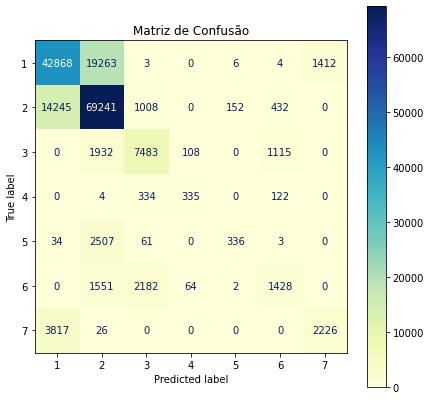

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(net_classifier_1, X_test_std, y_test, ax=ax, cmap='YlGnBu', values_format="")
plt.title('Matriz de Confusão')
plt.show()

- A **acurácia** do modelo de classificação no conjunto de teste:

In [ ]:
accuracy_score(y_test, y_pred)

0.7109245915182669

- A seguir temos o valor da medida **F-score**:

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.5229341637753284

- A **precisão** tem valor:

In [ ]:
precision_score(y_test, y_pred, average='macro')

0.6459567343273802

- O valor da **Revocação** é de:

In [ ]:
recall_score(y_test, y_pred, average='macro')

0.48105371779797906

- O parâmetro average='macro', calcula a métrica para cada rótulo, retornando a média não ponderada das métricas.

- Em relação as demais métricas, a acurácia apresenta uma medida superior comparado as outras métricas.

### 8. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 100 vezes  
   

```
8.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
8.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino 
```

In [ ]:
medidas = {'acuracias':[], 'fscores':[]}

for i in range(0, 100, 1):
    # particionando o dataset
    X_train, X_test, y_train, y_test = split_train_test(X, y)

    # escalonando os dados
    X_train_std, X_test_std = scaler(X_train, X_test)

    # treinando as redes neurais
    nnc = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', verbose=False, max_iter=300, shuffle=True, n_iter_no_change=5)
    nnc.fit(X_train_std, y_train)

    # testando a rede neural treinada
    y_pred = nnc.predict(X_test_std)
    
    # salvando os valores das metricas de cada treinamento
    medidas['acuracias'].append(accuracy_score(y_test, y_pred))
    medidas['fscores'].append(f1_score(y_test, y_pred, average='macro'))


- Média e desvio padrão das acurácias,  referentes aos resultados dos testes das redes neurais treinadas 100 vezes, utilizando o otimizador 'adam'

In [ ]:
np.mean(medidas['acuracias']), np.std(medidas['acuracias'])

(0.7153458899394161, 0.0033261912692833656)

- Média e desvio padrão dos F-scores,  referentes aos resultados dos testes das redes neurais treinadas 100 vezes, utilizando o otimizador 'adam'

In [ ]:
np.mean(medidas['fscores']), np.std(medidas['fscores'])

(0.5075793324476564, 0.01970957689783876)

- Visualizando os valores das métricas 

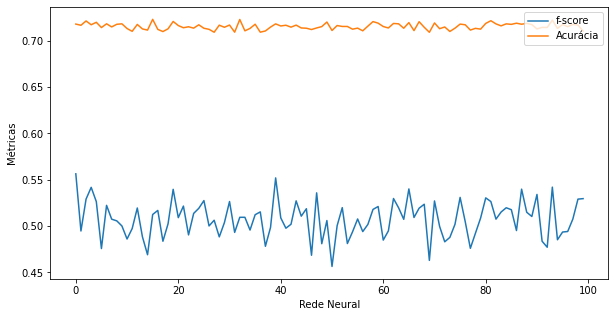

In [ ]:
b = list(range(0, n_iter))
plt.figure(figsize=(10,5))
plt.plot(b, medidas['fscores'], label='f-score')
plt.plot(b, medidas['acuracias'], label="Acurácia")
plt.xlabel('Rede Neural')
plt.ylabel('Métricas')
plt.legend(loc='upper right');

### 9. Repita por 100 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  

```
9.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino 
``` 

In [ ]:
medidas = {'acuracias':[], 'fscores':[]}

for i in range(0, 100, 1):
    # particionando o dataset
    X_train, X_test, y_train, y_test = split_train_test(X, y)

    # escalonando os dados
    X_train_std, X_test_std = scaler(X_train, X_test)

    # treinando as redes neurais
    nnc = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', verbose=False, max_iter=300, shuffle=True, n_iter_no_change=5)
    nnc.fit(X_train_std, y_train)

    # testando a rede neural treinada
    y_pred = nnc.predict(X_test_std)
    
    # salvando os valores das metricas
    medidas['acuracias'].append(accuracy_score(y_test, y_pred))
    medidas['fscores'].append(f1_score(y_test, y_pred, average='macro'))


- Média e desvio padrão das acurácias, referentes aos resultados dos testes das redes neurais treinadas 100 vezes, utilizando o otimizador 'sgd'

In [ ]:
np.mean(medidas['acuracias']), np.std(medidas['acuracias'])

(0.7131807072700569, 0.002791648893439712)

- Média e desvio padrão dos F-scores, referentes aos resultados dos testes das redes neurais treinadas 100 vezes, utilizando o otimizador 'sgd'

In [ ]:
np.mean(medidas['fscores']), np.std(medidas['fscores'])

(0.47914660301430323, 0.018705285713642397)

- Visualizando os valores das métricas 

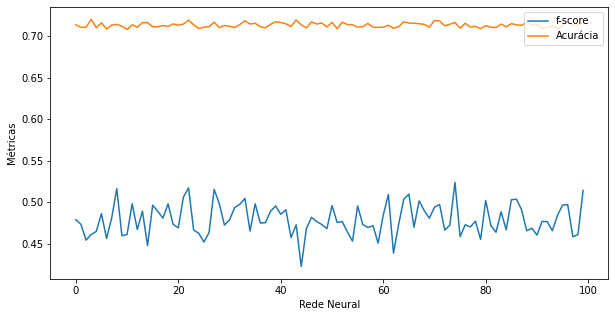

In [ ]:
b = list(range(0, n_iter))
plt.figure(figsize=(10,5))
plt.plot(b, medidas['fscores'], label='f-score')
plt.plot(b, medidas['acuracias'], label="Acurácia")
plt.xlabel('Rede Neural')
plt.ylabel('Métricas')
plt.legend(loc='upper right');

#### 10. Houve influência da escolha do otimizador no desempenho da rede?

Tendo em vista uma comparação do desempenho da rede utilizando diferentes hiperparâmetros. Realizou-se dois treinamentos, o primeiro treinamento com o otimizador 'adam' e o segundo treinamento com otimizador 'sgd'. Calculou-se a média e o desvio padrão da acurácia e F-Score dos dois treinamentos. Os resultados obtidos demonstraram uma pequena vantagem em desempenho na rede, quanto utilizado o otimizador 'adam'. Em relação a média das métricas de acurácia e f-score, obteve-se no primeiro treinamento uma média de acurácia de 0.7153 e uma média de F-Score de 0.5075, esse treinamento apresentou as maiores médias de desempenho. No entanto, a média da acurácia do segundo treinamento ficou adjacente a acurácia do primeiro treinamento, com uma média de 0.7131 e F-Score de 0.4791. Ambos os treinamentos obtiveram uma média de acurácia bem parecidas. Por outro lado, quando observado as médias de F-Score, o treinamento com o otimizador 'adam' apresenta uma média de F-Score superior comparado ao desempenho da rede do treinamento com o otimizador 'sgd'. Diante disso, pode-se dizer que a escolha de um otimizador, influência no desempenho da rede.

## Discussão

Nos passos anteriores, você avaliou o desempenho de uma única rede neural que contém os seguintes parâmetros: uma única camada oculta com 10 neurônios e função de ativação ReLU. O otimizador utilizado, quer seja SGD ou ADAM, trata-se do algoritmo para aproximar o gradiente do erro. Neste sentido, a escolha do otimizador é um hiperparâmetro, pois diz respeito a como a rede neural definida previamente atuará "em tempo de execução"  durante o processo de treinamento. Também são hiperparâmetros a quantidade de épocas, a taxa de aprendizado inicial, dentre outros.

Cabe alientar também que você efetuou o treinamento desta rede por 100 vezes e apresentou os resultados em termos de média +- desvio padrão. Lembre-se que em uma rede neural há a inicialização aleatória de pesos e, em consequência, o desempenho delas está sujeito à uma flutuação estocástica. A execução destas múltiplas vezes faz com que eliminemos algum viés introduzido por uma boa ou má "sorte" na escolha de pesos no caso de uma única execução.

Você também aprendeu uma estratégia para escalonar os atributos para uma melhor convergência da rede. Utilize-a em todos os treinamentos e testes propostos a seguir.

## Propondo Novas Arquiteturas

Variando  os parâmetros (uma ou duas camadas ocultas, com diferente números de neurônios em cada uma delas e a função de ativação) e o hiperparâmetros solver (Adam ou SGD) e o número de épocas (100,150 e 200), atenda ao que se pede:

1. Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha
2. Avalie cada uma das arquiteturas perante todos os hiperparâmetros apresentados por 100 vezes
3. Como resultado da avaliação, apresente:  
    3.1 Top-3 melhores redes no tocante à F-Score e Acurácia  
    3.2 Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn  

- Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha

In [59]:
parametros = {
    "hidden_layers": [(15,), (18,), (16, 17), (20, 30), (25, 35)],
    "solvers": ['adam', 'sgd'],
    "epochs": [100, 150, 200],
    "activation": ["identity", "logistic", "tanh", "relu"]
}

- Avalie cada uma das arquiteturas perante todos os hiperparâmetros apresentados por 100 vezes

In [ ]:
table = PrettyTable(["Camadas","Ativação", "Solver", "Épocas", "Neurônios", "Neurônios nas camadas"])        
table.padding_width = 1

general_metrics_net = []

qtd_redes = 1
while qtd_redes < 4:
    medidas = {'acuracias':[], 'fscores':[]}

    for i in range(0, 100, 1):

        # particionando o dataset
        X_train, X_test, y_train, y_test = split_train_test(X, y)

        # escalonando os dados
        X_train_std, X_test_std = scaler(X_train, X_test)
    
        # treinando as redes neurais
        hid_la = parametros["hidden_layers"][random.randint(0, 4)]
        sol = parametros["solvers"][random.randint(0, 1)]
        ep = parametros["epochs"][random.randint(0, 2)]
        act = parametros["activation"][random.randint(0, 3)]
        
        table.add_row([len(hid_la), act, sol, ep, np.sum(hid_la), hid_la])

        nnc = MLPClassifier(hidden_layer_sizes=hid_la, activation=act, solver=sol, verbose=False, max_iter=ep, shuffle=True, n_iter_no_change=5)
        nnc.fit(X_train_std, y_train)

        # testando a rede neural treinada
        y_pred = nnc.predict(X_test_std)
        
        #calculando as metricas
        acuracia = accuracy_score(y_test, y_pred)
        fscore = f1_score(y_test, y_pred, average='macro')

        # salvando os valores das metricas
        medidas['acuracias'].append(acuracia)
        medidas['fscores'].append(fscore)

        general_metrics_net.append((np.mean(medidas['acuracias']), np.mean(medidas['fscores']), nnc))

    qtd_redes += 1

- Top-3 melhores redes no tocante à F-Score e Acurácia 

In [ ]:
print(table)

- Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn 

In [ ]:
# ordenando em ordem descendente o Top-3 pela métrica de acurácia
general_metrics_net.sort(key=lambda x:x[0], reverse=True)

In [ ]:
classificadores = [general_metrics_net[0][2], # rede 1
        general_metrics_net[1][2],  # rede 2
        general_metrics_net[2][2]]  # rede 3

for classificador, label in zip(classificadores, ['Top-1', 'Top-2', 'Top-3']):
    fig, ax= plt.subplots(figsize=(7,7))
    plot_confusion_matrix(rede, X_test_std, y_test, ax=ax, cmap='YlGnBu', values_format="")
    plt.title('Matriz de Confusão '+label)
plt.show()

## Estimando o número de neurônios

Um dos problemas de pesquisa com redes neurais artificiais consiste na determinação do número de neurônios em sua arquitetura. Embora não seja possível definir a priori qual rede neural é adequada para um problema, pois isto só é possível mediante uma busca exaustiva, há regras na literatura que sugerem o número de neurônios escondidos, tal como a regra da Pirâmide Geométrica, dada a seguir:

$$N_h = \alpha \cdot \sqrt{N_i \cdot N_o},$$

em que $N_h$ é o número de neurônios ocultos (a serem distribuídos em uma ou duas camadas ocultas), $N_i$ é o número de neurônios na camada de entrada e $N_o$ é o número de neurônios na camada de saída. 

1. Consulte a documentação da classe MLPClassifier (disponível em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) e obtenha os valores de $N_i$ e $N_h$.
2. Teste os valores de $\alpha$ como sendo iguais a $0.5$, $2$ e $3$.
3. Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente  (solver, épocas, etc.)  
    3.1 Apresente as top-3 melhores redes no tocante à F-Score e Acurácia  

- Teste os valores de  α  como sendo iguais a  0.5 ,  2  e  3.

In [104]:
np.round((0.5 * sqrt(406708 * 7), 2 * sqrt(406708 * 7), 3 * sqrt(406708 * 7)))

array([ 844., 3375., 5062.])

- Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente (solver, épocas, etc.)

In [130]:
parametros2 = {
    "hidden_layers": [(844,), (3375,), (5062), (500, 343), (1000, 2374), (2000, 3061)],
    "solvers": ['adam', 'sgd'],
    "epochs": [100, 150, 200],
    "activation": ["identity", "logistic", "tanh", "relu"]
}

In [ ]:
table2 = PrettyTable(["Camadas","Ativação", "Solver", "Épocas", "Neurônios", "Neurônios nas camadas"])        
table2.padding_width = 1

general_metrics_net_2 = []

qtd_redes = 1
while qtd_redes < 4:
    medidas2 = {'acuracias':[], 'fscores':[]}

    for i in range(0, 100, 1):

        # particionando o dataset
        X_train, X_test, y_train, y_test = split_train_test(X, y)

        # escalonando os dados
        X_train_std, X_test_std = scaler(X_train, X_test)
    
        # treinando as redes neurais
        hid_la = parametros2["hidden_layers"][random.randint(0, 4)]
        sol = parametros2["solvers"][random.randint(0, 1)]
        ep = parametros2["epochs"][random.randint(0, 2)]
        act = parametros2["activation"][random.randint(0, 3)]
        
        table2.add_row([len(hid_la), act, sol, ep, np.sum(hid_la), hid_la])

        nnc2 = MLPClassifier(hidden_layer_sizes=hid_la, activation=act, solver=sol, verbose=False, max_iter=ep, shuffle=True, n_iter_no_change=5)
        nnc2.fit(X_train_std, y_train)

        # testando a rede neural treinada
        y_pred = nnc.predict(X_test_std)
        
        # salvando os valores das metricas
        medidas2['acuracias'].append(accuracy_score(y_test, y_pred))
        medidas2['fscores'].append(f1_score(y_test, y_pred, average='macro'))

        general_metrics_net_2.append((np.mean(medidas2['acuracias']), np.mean(medidas2['fscores']), nnc2))

    qtd_redes += 1

- Apresente as top-3 melhores redes no tocante à F-Score e Acurácia

In [ ]:
print(table)

## Testando as Redes Neurais com Atributos Categóricos

1. Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)
2. Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 100 repetições  
    2.1 Considere o melhor otimizador para cada uma delas  
    2.2 Faça uso de 200 épocas para treinamento  
    2.2 Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura
3. Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante as 100 repetições

- Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)

In [30]:
# ordenando em ordem descendente o Top-3 pela métrica de acurácia
general_metrics_net_2.sort(key=lambda x:x[0])

# definindo as 6 redes neurais
redes = [general_metrics_net[0][2], general_metrics_net[1][2], general_metrics_net[2][2], general_metrics_net_2[0][2], general_metrics_net_2[1][2], general_metrics_net_2[2][2]]

- Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 100 repetições  
   


In [44]:
database2 = pd.read_csv('database/covtype.csv')
X = database2.iloc[:,:-1]
y = database.Cover_Type

- Considere o melhor otimizador para cada uma delas  


In [49]:
# definindo o otimizador das redes
otimizador = 'sgd'

for i in range(6):
    redes[i].solver = otimizador

- Faça uso de 200 épocas para treinamento

In [54]:
# definindo o máximo de épocas das redes
epocas = 200

for i in range(6):
    redes[i].max_iter = epocas

In [42]:
acuracia = PrettyTable(["Arquitetura", "Média", "Desvio Padrão"])
fscore = PrettyTable(["Arquitetura", "Média", "Desvio Padrão"])
boxplot = []
arquitetura = 1
table2.padding_width = 1

for classifier in redes:
        
    medidas3 = {'acuracias':[], 'fscores':[]}

    for i in range(0, 100, 1):

        # particionando o dataset
        X_train, X_test, y_train, y_test = split_train_test(X, y)

        # escalonando os dados
        X_train_std, X_test_std = scaler(X_train, X_test)
        
        # treinando a rede
        classifier.fit(X_train_std, y_train)

        # testando a rede neural treinada
        y_pred = classifier.predict(X_test_std)
        
        # salvando os valores das metricas
        medidas3['acuracias'].append(accuracy_score(y_test, y_pred))
        medidas3['fscores'].append(f1_score(y_test, y_pred, average='macro'))
    
        acuracia.add_row([arquitetura, medidas3['acuracias'].mean(), medidas3['acuracias'].std()])
        fscore.add_row([arquitetura, medidas3['fscores'].mean(), medidas3['fscores'].std()])
        boxplot.append(medidas3['fscores'].mean())
    arquitetura +=1 


- Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura

In [ ]:
print(acuracia)

In [ ]:
print(fscore)

- Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante as 100 repetições

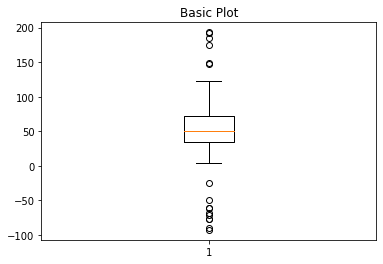

In [58]:
for i in range(len(boxplot)):

    fig, ax = plt.subplots()
    ax.set_title('Arquitetura '+i)
    ax.boxplot(boxplot[i])
    plt.show()

## Considerações Parciais

1. É possível identificar uma rede com desempenho superior às demais?
2. Qual estratégia mostrou-se mais producente para a obtenção de boas arquiteturas (Estratégia Própria ou Pirâmide Geométrica)? Por quê?
3. Considerar os atributos categóricos trouxe melhorias? Justifique.
4. Um número maior de épocas trouxe melhorias?
5. Qual a maior dificuldade de resolução do problema proposto perante as RNAs?